In [1]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, chisquare
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# sharper plots
%config InlineBackend.figure_format = 'retina'

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [4]:
companies_df = pd.read_csv("E:/.ML/[Анатолий Карпов] [Stepic] Data Analytic Часть 1/3/Задания/companies.csv")

In [350]:
companies_df.head()

,company;income;date
ЗАО «Доронин,Колобов и Калашникова»;1221331958;2019-09-09
ООО «Авдеев»;21116804375;1972-12-21,NaN
РАО «Аксенов Сорокина»;79257158759;2007-03-05,NaN
Ларионов Инкорпорэйтед;36799366126;2011-08-11,NaN
Григорьев Инкорпорэйтед;48201837498;1989-09-02,NaN


In [351]:
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, ЗАО «Доронин to ОАО «Жданова»;40620723709;2016-04-19
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   company;income;date  52 non-null     object
dtypes: object(1)
memory usage: 12.7+ KB


In [352]:
# Оказывается в методе read_csv есть параметр sep, поэтому эта функа бесполезна :)
def prettify(path:str):
    df = pd.read_csv(path)
    cols = [col.split(";") for col in df.columns][0]
    notnull_df = df[df.iloc[:,0].isnull() == False].reset_index()
    null_values_df = df[df.iloc[:,0].isnull()].reset_index()
    notnull_df = (notnull_df["index"] + notnull_df["company;income;date"]).apply(lambda x: x.split(";"))
    null_values_df = null_values_df["index"].apply(lambda x: x.split(";"))
    
    series = pd.concat([notnull_df, null_values_df]).reset_index()[0]
    ret_df = pd.DataFrame(data=series.to_list(), columns=cols)
    
    return ret_df

In [380]:
df = pd.read_csv("E:/.ML/[Анатолий Карпов] [Stepic] Data Analytic Часть 1/3/Задания/companies.csv", sep=";")
df.head()

,company,income,date
0,"ЗАО «Доронин, Колобов и Калашникова»",1221331958,2019-09-09
1,ООО «Авдеев»,21116804375,1972-12-21
2,РАО «Аксенов Сорокина»,79257158759,2007-03-05
3,Ларионов Инкорпорэйтед,36799366126,2011-08-11
4,Григорьев Инкорпорэйтед,48201837498,1989-09-02


In [381]:
def read_n_agg(path:str):
    df = prettify(path)
    df.income = df.income.astype(np.longlong)
    ret = df.groupby("company", as_index=True).mean()
    return ret

In [373]:
read_n_agg("E:/.ML/[Анатолий Карпов] [Stepic] Data Analytic Часть 1/3/Задания/companies.csv")

,income
company,
En +,9.962187e+10
АО «Александрова Савельев и Мельникова»,7.206782e+10
АО «Андреев-Анисимов»,6.931948e+09
АО «Андреев-Макарова»,8.934380e+10
АО «Большаков Кошелева»,7.860861e+10
...,...
Щекиноазот,4.309092e+10
Щукин Лимитед,6.703036e+10
Эйвон Бьюти Продактс Компани (Avon),2.503657e+10


In [406]:
taxi_df = pd.read_csv("E:/.ML/[Анатолий Карпов] [Stepic] Data Analytic Часть 1/3/Задания/taxi_peru.csv", 
                      sep=";",
                      parse_dates=['start_at', 'end_at', 'arrived_at'])
taxi_df.head()


,journey_id,user_id,driver_id,taxi_id,icon,start_type,start_at,start_lat,start_lon,end_at,end_lat,end_lon,end_state,driver_start_lat,driver_start_lon,arrived_at,source,driver_score,rider_score
0,23a1406fc6a11d866e3c82f22eed4d4c,0e9af5bbf1edfe591b54ecdfd7e91e26,583949a89a9ee17d19e3ca4f137b6b4c,b12f4f09c783e29fe0d0ea624530db56,executive,asap,2010-11-16 16:44:00,"-12,13983536","-77,02355957",2010-11-16 17:29:00,"-12,05537033","-77,0413208",drop off,"-12,10825481","-77,0272739",2010-11-16 17:02:00,iPhone,5.0,5.0
1,dd2af4715d0dc16eded53afc0e243577,a553c46e3a22fb9c326aeb3d72b3334e,NaN,NaN,executive,asap,2010-06-01 00:34:00,"-12,13874817","-76,99536133",2010-06-01 00:37:00,"-12,12465668","-77,02886963",not found,NaN,NaN,NaT,iPhone,NaN,NaN
2,dd91e131888064bf7df3ce08f3d4b4ad,a553c46e3a22fb9c326aeb3d72b3334e,NaN,NaN,executive,asap,2010-05-31 05:01:00,"-12,12453079","-77,02780151",2010-05-31 05:04:00,"-12,13883209","-76,99530029",not found,NaN,NaN,NaT,iPhone,NaN,NaN
3,dd2af4715d0dc16eded53afc0e2466d0,a553c46e3a22fb9c326aeb3d72b3334e,NaN,NaN,executive,asap,2010-06-01 00:29:00,"-12,13885117","-76,99530029",2010-06-01 00:32:00,"-12,12458801","-77,02896118",not found,NaN,NaN,NaT,iPhone,NaN,NaN
4,85b7eabcf5d84e42dc7629b7d27781af,56772d544fdfa589a020a1ff894a86f7,d665fb9f75ef5d9cd0fd89479380ba78,0accdd3aa5a322f4129fa20b53278c69,executive,reserved,2010-09-11 23:55:00,"-12,08995438","-76,92626953",2010-09-12 01:07:00,"-12,02223206","-77,10638428",drop off,"-12,08311558","-76,9277072",2010-09-11 23:50:00,iPhone,4.0,5.0


In [422]:
round(taxi_df.source.value_counts(normalize=True, dropna=True).mul(100).max())

42

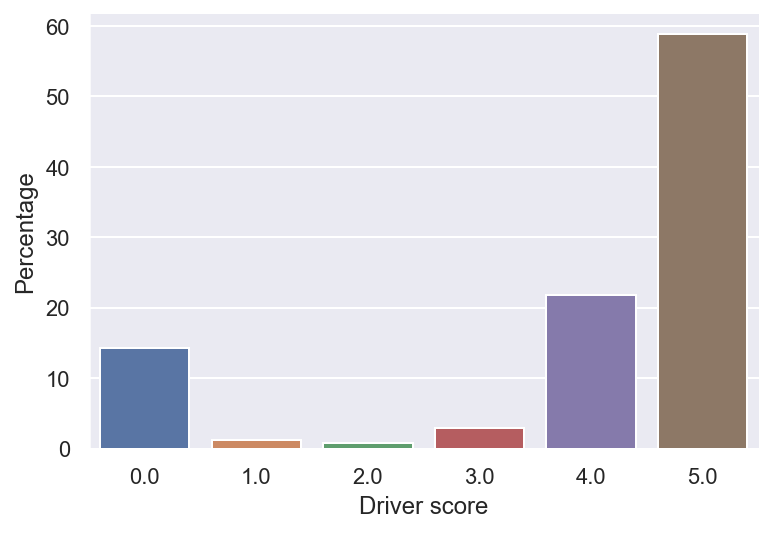

In [439]:
driver_score_counts = round(taxi_df["driver_score"].value_counts(normalize=True, dropna=True).mul(100), 2)\
                        .reset_index()\
                        .rename(columns={"index":"driver_score", "driver_score":"percentage"}) \
                        .sort_values(by='driver_score')
ax = sns.barplot(x='driver_score', y='percentage', data=driver_score_counts);
ax.set(xlabel='Driver score', ylabel='Percentage')
sns.despine()  # убрать часть рамки графика
plt.show()

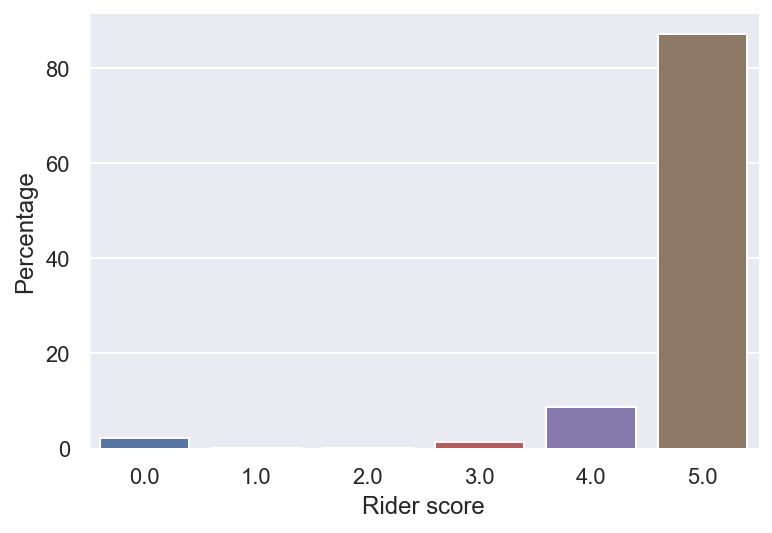

In [443]:
rider_score_counts = round(taxi_df["rider_score"].value_counts(normalize=True, dropna=True).mul(100), 2)\
                        .reset_index()\
                        .rename(columns={"index":"rider_score", "rider_score":"percentage"}) \
                        .sort_values(by='rider_score')
ax = sns.barplot(x='rider_score', y='percentage', data=rider_score_counts);
ax.set(xlabel='Rider score', ylabel='Percentage')
sns.despine()  # убрать часть рамки графика
plt.show()

# 2nd Part

In [459]:
logs = pd.read_csv("E:/.ML/[Анатолий Карпов] [Stepic] Data Analytic Часть 1/3/Задания/Минипроект/logs.csv")
user_data = pd.read_csv("E:/.ML/[Анатолий Карпов] [Stepic] Data Analytic Часть 1/3/Задания/Минипроект/user_data.csv")
print(logs.head())
print(user_data.head())

   client  success  platform        time
0   40177     True     phone  1585412212
1   61468     True     phone  1585425658
2   35604    False     phone  1585459894
3    9961     True     phone  1585400189
4   10931     True  computer  1585468629
   client  premium  age
0   46346    False   58
1    4391    False   55
2   27372    False   64
3   11989    False   44
4   60664    False   49


In [480]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2954 entries, 0 to 2953
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   client   2954 non-null   int64
 1   premium  2954 non-null   bool 
 2   age      2954 non-null   int64
dtypes: bool(1), int64(2)
memory usage: 49.2 KB


In [460]:
user_data.any() == np.nan

client     False
premium    False
age        False
dtype: bool

In [452]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   client    4500 non-null   int64 
 1   success   4500 non-null   bool  
 2   platform  4500 non-null   object
 3   time      4500 non-null   int64 
dtypes: bool(1), int64(2), object(1)
memory usage: 110.0+ KB


In [458]:
logs.any() == np.nan

client      False
success     False
platform    False
time        False
dtype: bool

In [474]:
set(user_data.client) - set(logs.client)

set()

#### Какой клиент совершил больше всего успешных операций? (success == True)

In [514]:
max_success_num = logs[logs.success == True].groupby("client").platform.count().max()
success_numbers = logs[logs.success == True].groupby("client", as_index=False)\
                        .agg({"platform":'count'})\
                        .rename(columns={'platform':'success_number'})
success_numbers.query('success_number == @max_success_num')

,client,success_number
332,12179,41
810,28719,41
1020,36165,41
1487,52870,41
1758,61468,41
1759,61473,41
2231,78349,41
2345,82563,41
2626,92584,41


#### С какой платформы осуществляется наибольшее количество успешных операций?

In [516]:
merged_table = user_data.merge(logs[logs.success == True], on='client')
merged_table[merged_table.success == True].platform.value_counts().idxmax()

'phone'

#### Какую платформу предпочитают премиумные клиенты?

In [520]:
merged_table.query('premium == True').platform.value_counts().idxmax()

'phone'

#### Визуализируйте распределение возраста клиентов в зависимости от типа клиента (премиум или нет)

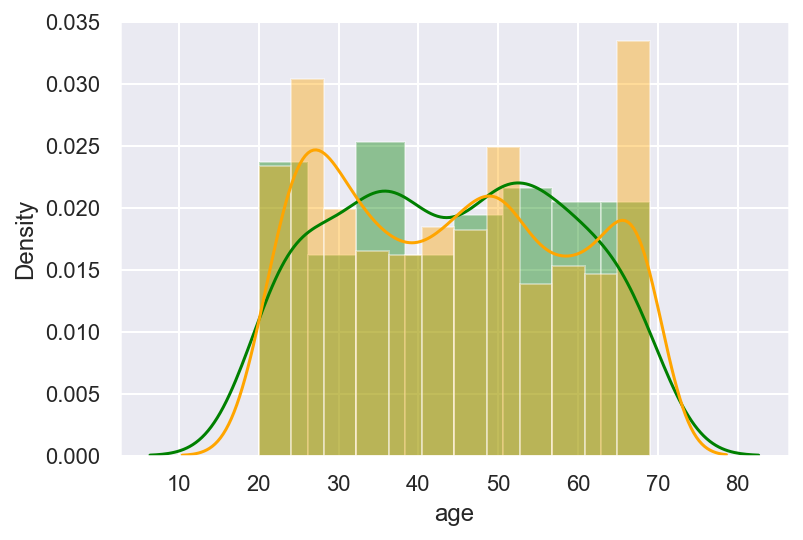

In [540]:
sns.distplot(merged_table.query('premium == True').age, color='green');
sns.distplot(merged_table.query('premium == False').age, color='orange');

#### Постройте график распределения числа успешных операций


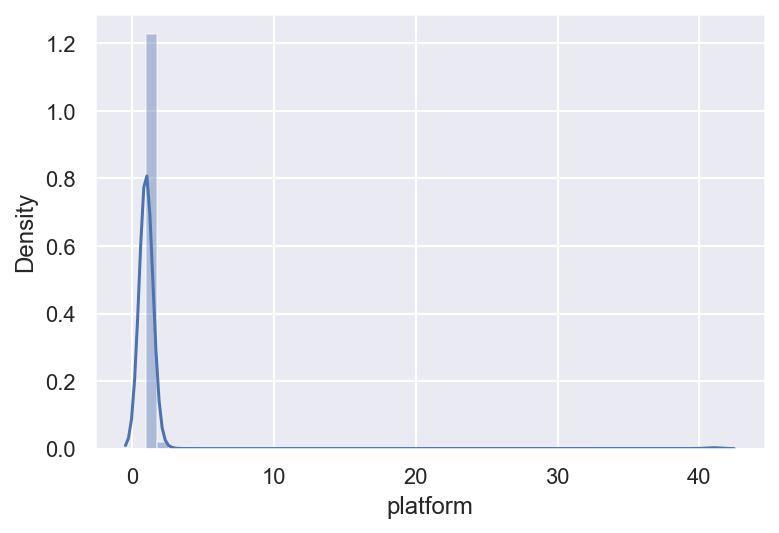

In [542]:
sns.distplot(logs[logs.success == True].groupby("client").platform.count());

In [544]:
logs[logs.success == True].groupby("client").platform.count().value_counts()

1     2791
2       43
41       9
40       1
3        1
Name: platform, dtype: int64

#### Визуализируйте число успешных операций, сделанных на платформе computer, в зависимости от возраста, используя sns.countplot (x – возраст, y – число успешных операций). Клиенты какого возраста совершили наибольшее количество успешных действий?

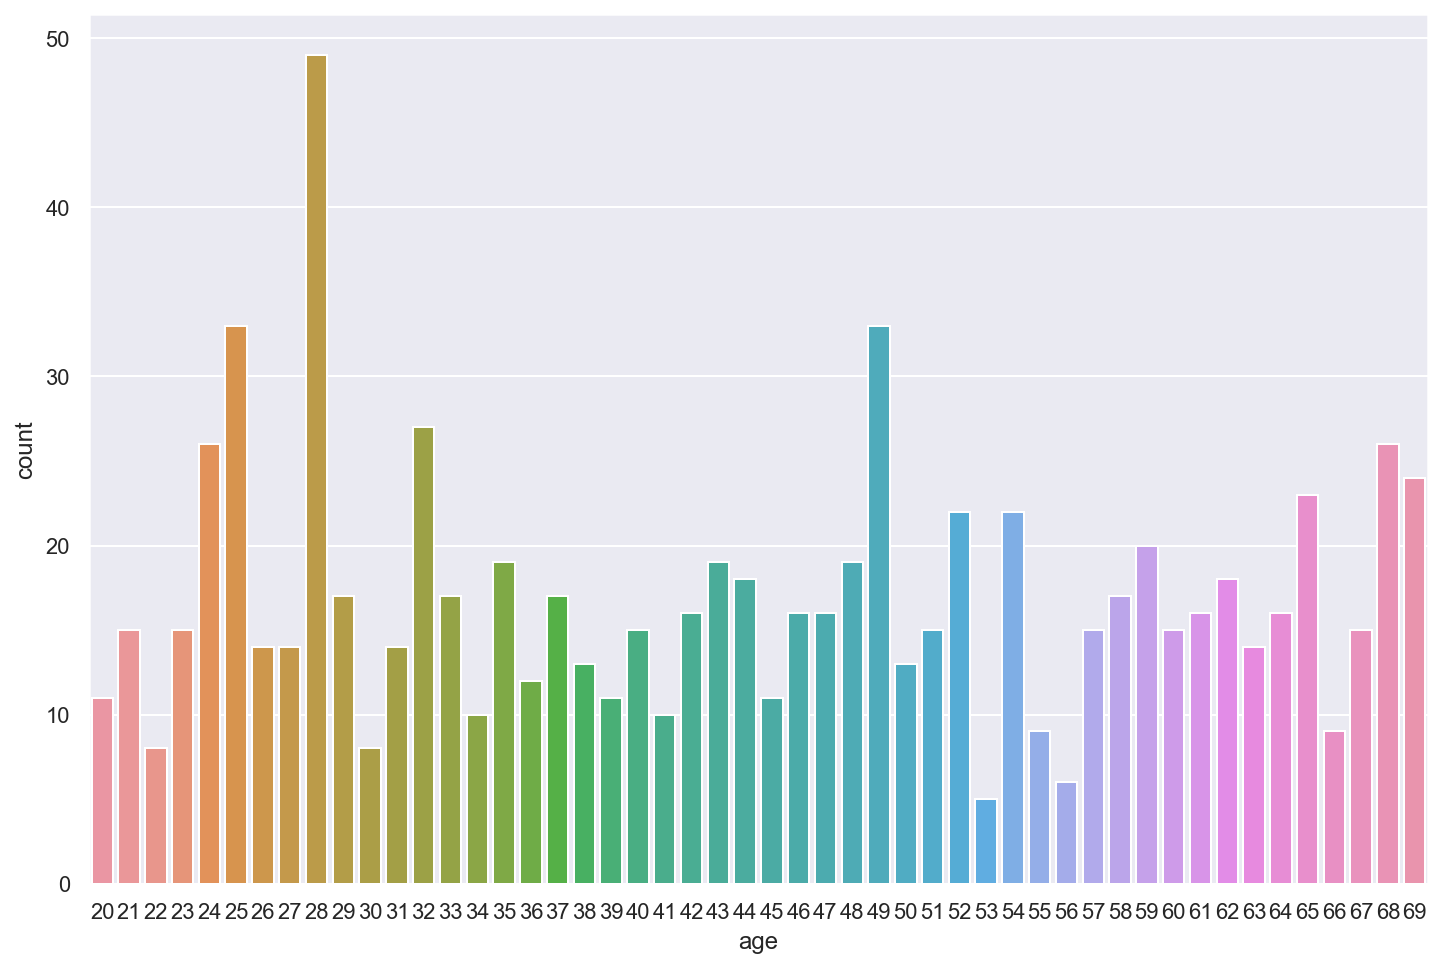

In [547]:
plt.figure(figsize=(12,8))
sns.countplot(x="age", data=merged_table.query("(success == True) & (platform == 'computer')"));